### Project Smart ict-systemen

* Beschrijving

Voor dit project is besloten om het k-means algoritme te implementeren. Het doel is om voetballers te clusteren in drie groepen op basis van hun vaardigheden. Deze groepen vertegenwoordigen de verdedigers, middenvelders en aanvallers. De vaardigheden van de spelers zijn afkomstig uit het spel FIFA 23 en kunnen worden gevonden op de volgende link: https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset

* Werking van k-means

1. Willekeurig k punten uit de dataset initialiseren als centroids
2. Afstand tussen elke sampel en centroid berekenen
3. Elke sampel toewijzen aan het dichtstbijzijnde centroid
4. Gemiddelde van alle sampels in elk cluster berekenen en deze gemiddelden als de nieuwe centroids van de cluster instellen
5. Stappen 2 t.e.m. 4 herhalen tot als de centroids stabiel zijn

In deze toepassing wordt de waarde van k ingesteld op 3.


In [92]:
k = 3 # aantal clusters 

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

* Data verkennen

In [93]:

fifa_data= pd.read_csv('male_players (legacy).csv',low_memory=False)

In ons geval zijn we uitsluitend geïnteresseerd in de gegevens van de meest recente versie van het spel FIFA 23. Daarnaast behouden we alleen de spelers wiens voetbalvaardigheden zijn ontwikkeld, om te voorkomen dat jongere spelers de classificatie minder nauwkeurig maken.

In [94]:
fifa_data = fifa_data[fifa_data['fifa_version'] == 23]
fifa_data = fifa_data[fifa_data['fifa_update'] == 2]
fifa_data = fifa_data[fifa_data['overall'] >= 75]

In [95]:
fifa_data.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
143050,158023,/player/158023/lionel-messi/230002,23,2,2022-09-26,L. Messi,Lionel Andrés Messi Cuccittini,RW,91,91,...,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3,https://cdn.sofifa.net/players/158/023/23_120.png
143051,165153,/player/165153/karim-benzema/230002,23,2,2022-09-26,K. Benzema,Karim Benzema,"CF, ST",91,91,...,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3,https://cdn.sofifa.net/players/165/153/23_120.png
143052,188545,/player/188545/robert-lewandowski/230002,23,2,2022-09-26,R. Lewandowski,Robert Lewandowski,ST,91,91,...,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/23_120.png
143053,192985,/player/192985/kevin-de-bruyne/230002,23,2,2022-09-26,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,79+3,79+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/23_120.png
143054,231747,/player/231747/kylian-mbappe/230002,23,2,2022-09-26,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,95,...,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3,https://cdn.sofifa.net/players/231/747/23_120.png


Na een eerste zicht van de gegevens is gebleken dat sommige spelers op meerdere posities kunnen spelen, wat later tijdens het testen van het algoritme problematisch kan zijn. Daarom is ervoor gekozen om voor spelers met meerdere posities alleen de eerste positie te behouden.

In [96]:
position = fifa_data['player_positions'].str.split(',').str[0]
fifa_data['player_positions'] = position

Alleen de vaardigheden van de spelers zijn relevant, met uitzondering van de vaardigheden van de keepers, die niet zijn behouden omdat spelers op die positie geen beoordeling hadden.

In [97]:
players = fifa_data[['pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle']].copy()


In [98]:
players.head()

,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
143050,81.0,89.0,90.0,94.0,34.0,64.0,84,90,70,91,...,91,44,40,93,94,75,96.0,20,35,24
143051,80.0,88.0,83.0,87.0,39.0,78.0,75,92,90,89,...,80,63,39,92,89,84,90.0,43,24,18
143052,75.0,91.0,79.0,86.0,44.0,83.0,71,94,91,84,...,84,81,49,94,81,90,88.0,35,42,19
143053,74.0,88.0,93.0,87.0,64.0,77.0,94,85,55,93,...,91,75,66,88,94,83,89.0,68,65,53
143054,97.0,89.0,80.0,92.0,36.0,76.0,78,93,72,85,...,82,64,38,92,83,80,88.0,26,34,32


Er wordt ook gecontroleerd of er lege rijen aanwezig zijn in de gegevens.

In [99]:
players = players.dropna()
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 143050 to 144935
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pace                         1699 non-null   float64
 1   shooting                     1699 non-null   float64
 2   passing                      1699 non-null   float64
 3   dribbling                    1699 non-null   float64
 4   defending                    1699 non-null   float64
 5   physic                       1699 non-null   float64
 6   attacking_crossing           1699 non-null   int64  
 7   attacking_finishing          1699 non-null   int64  
 8   attacking_heading_accuracy   1699 non-null   int64  
 9   attacking_short_passing      1699 non-null   int64  
 10  attacking_volleys            1699 non-null   int64  
 11  skill_dribbling              1699 non-null   int64  
 12  skill_curve                  1699 non-null   int64  
 13  skill_fk_ac

De vaardigheden van de spelers in het spel liggen allemaal op dezelfde schaal, namelijk tussen 0 en 100. Daarom is normalisatie van de data in ons geval niet nodig.

In [100]:
players.describe()

,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
count,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,...,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000
mean,72.303119,65.057092,70.540318,74.402001,61.492054,72.114185,66.598587,62.773396,65.808711,75.828723,...,64.755150,70.264273,60.922896,68.051207,69.763979,60.642142,74.955856,61.007652,61.904650,58.141260
std,11.546722,13.416923,7.679918,7.543452,17.807580,8.280202,12.650792,16.161212,12.665090,5.423369,...,14.861436,12.227870,20.275065,14.483664,10.976266,13.582198,6.136727,18.830296,20.311249,21.268934
min,31.000000,20.000000,44.000000,41.000000,20.000000,35.000000,17.000000,17.000000,20.000000,56.000000,...,15.000000,26.000000,11.000000,20.000000,22.000000,17.000000,52.000000,10.000000,11.000000,10.000000
25%,66.000000,57.000000,66.000000,71.000000,44.000000,67.000000,60.000000,52.000000,58.000000,73.000000,...,59.000000,63.500000,42.000000,63.000000,65.000000,51.000000,71.000000,44.000000,44.000000,37.500000
50%,74.000000,69.000000,72.000000,76.000000,70.000000,74.000000,69.000000,68.000000,68.000000,76.000000,...,69.000000,73.000000,71.000000,73.000000,72.000000,62.000000,75.000000,69.000000,72.000000,69.000000
75%,81.000000,75.000000,76.000000,79.000000,76.000000,78.000000,75.000000,75.000000,76.000000,79.000000,...,75.000000,79.000000,77.000000,77.000000,77.000000,71.000000,79.000000,76.000000,78.000000,75.000000
max,97.000000,92.000000,93.000000,94.000000,91.000000,90.000000,94.000000,94.000000,93.000000,93.000000,...,91.000000,94.000000,91.000000,96.000000,94.000000,92.000000,96.000000,92.000000,93.000000,90.000000


* Implementatie

In [101]:
# stap 1
def init_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [102]:
# stap 2
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [103]:
# stap 3 en 4
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [104]:

def plot_it(data, labels, centroids):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1],marker = 'x',c = 'k')
    plt.show()

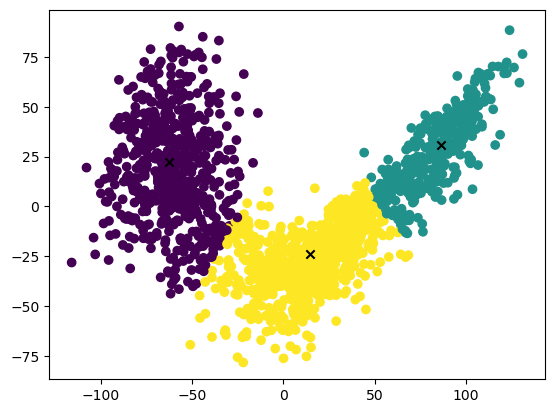

In [105]:
# main 
max_iterations = 100
centroid_count = k
centroids = init_centroids(players, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(players, centroids)
    centroids= new_centroids(players, labels, centroid_count)
    iteration += 1
plot_it(players, labels, centroids)

* Bespreking van de resultaten

In [106]:
# Vaardigheden van de 3 clusters
centroids.head()

,0,1,2
pace,76.968280,63.400606,70.350556
shooting,75.320914,42.282033,65.397223
passing,70.861317,60.189698,74.023981
dribbling,78.286633,62.518765,75.866483
defending,38.708465,78.200260,71.588706


In [149]:
# Aantal aanvallers, middenvelders en verdedigers bepaald door het algoritme 
prediction = pd.DataFrame(labels,columns=['Label'])
y =  prediction['Label'].value_counts()
pred_num_att = prediction.value_counts()[0]
pred_num_mid = prediction.value_counts()[2]
pred_num_def = prediction.value_counts()[1]


In [133]:
pos_att = np.array(['ST','CF','LF','RF','RW','LW'])
pos_mid = np.array(['LM','CM','CAM','CM','CDM','RM','LWB','RWB'])
pos_def = np.array(['LB','CB','RB'])

In [140]:
# Aantal aanvallers, middenvelders en verdedigers in de dataset
real_pos = fifa_data[['player_positions']].copy()
num_att = real_pos.apply(lambda x:x.isin(pos_att)).value_counts()[1]
num_mid = real_pos.apply(lambda x:x.isin(pos_mid)).value_counts()[1]
num_def = real_pos.apply(lambda x:x.isin(pos_def)).value_counts()[1]


<function matplotlib.pyplot.show(close=None, block=None)>

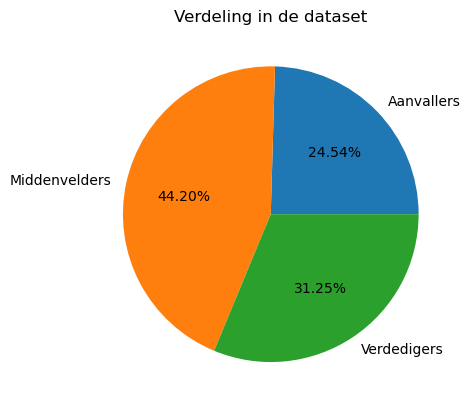

In [156]:
plt.pie([num_att,num_mid,num_def],labels = ['Aanvallers', 'Middenvelders','Verdedigers'],autopct= '%.2f%%')
plt.title('Verdeling in de dataset')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

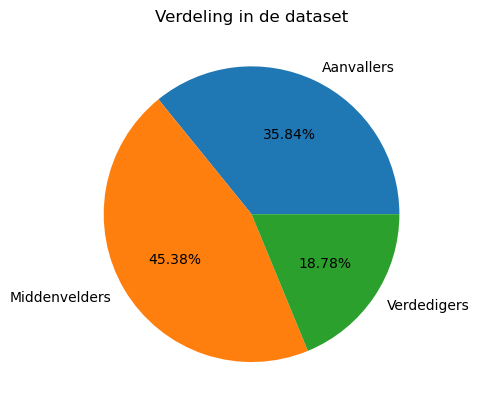

In [157]:
plt.pie([pred_num_att,pred_num_mid,pred_num_def],labels = ['Aanvallers', 'Middenvelders','Verdedigers'],autopct= '%.2f%%')
plt.title('Verdeling in de dataset')
plt.show

De implementatie van het k-means algoritme voor het voorspellen van spelersposities in FIFA op basis van hun vaardigheden heeft bemoedigende resultaten opgeleverd. Het algoritme heeft met succes spelers geclusterd in verschillende groepen op basis van hun vaardigheden, waardoor in de meeste gevallen accurate positievoorspellingen konden worden gedaan.

Er werd echter een opmerkelijke beperking van het model waargenomen met betrekking tot de classificatie van verdedigers die aan de zijkanten spelen, die vaak als middenvelders werden gecategoriseerd. Deze verkeerde classificatie kan worden toegeschreven aan de vergelijkbare vaardigheden van deze spelers, waardoor het moeilijk is om ze alleen op basis van hun vaardigheden te onderscheiden.

Daarnaast is het belangrijk om te weten dat bepaalde spelers in FIFA op verschillende posities kunnen spelen. Deze flexibiliteit vormt een uitdaging voor het k-means algoritme, omdat het zich voornamelijk richt op het clusteren van spelers in verschillende positiegroepen. Het algoritme kan echter moeite hebben om de genuanceerde vaardigheid vast te leggen van spelers die de vaardigheden bezitten om op meerdere posities goed te prestere

Ondanks deze beperking blijft de algemene prestatie van het k-means algoritme bevredigend . Het identificeerde effectief patronen en overeenkomsten tussen spelers, waardoor in de meeste gevallen betrouwbare voorspellingen van spelersposities mogelijk waren.